## Notebook for model development to predict impact of industry. 

In [1]:
#Import libraries 
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 
import ee

It's not necesary to connect to google earth engine, but it was done for data query's (That's how LST and Wind info was gather)

In [2]:
ee.Authenticate()
ee.Initialize(project='greengrowth-474103')

In [3]:
data = '../data/ghgp_data_2023.xlsx'


try:
    data_sheets = pd.ExcelFile(data).sheet_names
    print("Data_sheets found:", data_sheets)
except Exception as e:
    print(f"Error reading data: {e}")


try:
    sheet = data_sheets[0] if data_sheets else None

    df_ghg = pd.read_excel(data, sheet_name=sheet ,header=3)
    print(df_ghg.info())

except Exception as e:
    print(f"\nError al cargar la hoja: {e}")

Data_sheets found: ['Direct Point Emitters', 'Onshore Oil & Gas Prod.', 'Gathering & Boosting', 'Transmission Pipelines', 'LDC - Direct Emissions', 'SF6 from Elec. Equip.', 'Suppliers', 'CO2 Injection', 'Geologic Sequestration of CO2', 'Industry Type', 'FAQs about this Data']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6470 entries, 0 to 6469
Data columns (total 66 columns):
 #   Column                                                                                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                                                                                     --------------  -----  
 0   Facility Id                                                                                                                                                                        

In [4]:
df_ghg.head()

,Facility Id,FRS Id,Facility Name,City,State,Zip Code,Address,County,Latitude,Longitude,Primary NAICS Code,Industry Type (subparts),Industry Type (sectors),Total reported direct emissions,CO2 emissions (non-biogenic),Methane (CH4) emissions,Nitrous Oxide (N2O) emissions,HFC emissions,PFC emissions,SF6 emissions,NF3 emissions,Other Fully Fluorinated GHG emissions,HFE emissions,Very Short-lived Compounds emissions,Other GHGs (metric tons CO2e),Biogenic CO2 emissions (metric tons),Stationary Combustion,Electricity Generation,Adipic Acid Production,Aluminum Production,Ammonia Manufacturing,Cement Production,Electronics Manufacture,Ferroalloy Production,Fluorinated GHG Production,Glass Production,HCFC–22 Production from HFC–23 Destruction,Hydrogen Production,Iron and Steel Production,Lead Production,Lime Production,Magnesium Production,Miscellaneous Use of Carbonates,Nitric Acid Production,Petroleum and Natural Gas Systems – Offshore Production,Petroleum and Natural Gas Systems – Processing,Petroleum and Natural Gas Systems – Transmission/Compression,Petroleum and Natural Gas Systems – Underground Storage,Petroleum and Natural Gas Systems – LNG Storage,Petroleum and Natural Gas Systems – LNG Import/Export,Petrochemical Production,Petroleum Refining,Phosphoric Acid Production,Pulp and Paper Manufacturing,Silicon Carbide Production,Soda Ash Manufacturing,Titanium Dioxide Production,Underground Coal Mines,Zinc Production,Municipal Landfills,Industrial Wastewater Treatment,Manufacture of Electric Transmission and Distribution Equipment,Industrial Waste Landfills,Is some CO2 collected on-site and used to manufacture other products and therefore not emitted from the affected manufacturing process unit(s)? (as reported under Subpart G or S),"Is some CO2 reported as emissions from the affected manufacturing process unit(s) under Subpart AA, G or P collected and transferred off-site or injected (as reported under Subpart PP)?",Does the facility employ continuous emissions monitoring?
0,1013701,1.100709e+11,30-30 Gas Plant,Plains,TX,79355,2300 FM 1622,YOAKUM COUNTY,33.051880,-102.887920,211130.0,"C,PP,RR (RPT),W-PROC","Injection of CO2,Petroleum and Natural Gas Sys...",44170.546,43895.8,259.25,15.496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27874.396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16296.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N
1,1012037,1.100638e+11,50 Buttes Gas Plant,Gillette,WY,82716,3669 South Hwy 50,CAMPBELL COUNTY,43.852740,-105.777810,213112.0,"C,W-PROC",Petroleum and Natural Gas Systems,61389.032,58078.3,3278.25,32.482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55537.340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5851.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N
2,1010475,NaN,AJAX PLANT,Wheeler,TX,79014,16600 CR N,NaN,35.546399,-100.116256,211130.0,"C,W-PROC",Petroleum and Natural Gas Systems,38738.508,38053.6,663.75,21.158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36776.912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961.596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N
3,1003129,1.100622e+11,AKER PLANT,STREETMAN,TX,75859,261 FCR 181,FREESTONE COUNTY,31.910000,-96.223300,211130.0,"C,PP,W-PROC","Petroleum and Natural Gas Systems,Suppliers of...",39758.102,39504.3,231.75,22.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38867.104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,890.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N
4,1005887,1.100706e+11,ALLIANCE COMPRESSOR STATION,JUSTIN,TX,76247,12495 HWY 114,DENTON COUNTY,33.035120,-97.331434,211130.0,"C,W-PROC",Petroleum and Natural Gas Systems,48988.056,46801.0,2180.50,6.556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11753.756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37234.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [5]:
df_ghg.isnull().sum()

Facility Id                                                                                                                                                                                     0
FRS Id                                                                                                                                                                                        318
Facility Name                                                                                                                                                                                   0
City                                                                                                                                                                                            0
State                                                                                                                                                                                           0
                              

In [6]:
df_ghg.columns = df_ghg.columns.str.strip()
data_selected = [
    'Latitude', 
    'Longitude', 
    'Industry Type (subparts)', 
    'Industry Type (sectors)', 
    'Stationary Combustion',      
    'Total reported direct emissions',  
    'Methane (CH4) emissions',    
    'CO2 emissions (non-biogenic)', 
    'Nitrous Oxide (N2O) emissions' 
]
df = df_ghg[data_selected]
print(df)

       Latitude   Longitude Industry Type (subparts)                            Industry Type (sectors)  Stationary Combustion  Total reported direct emissions  Methane (CH4) emissions  CO2 emissions (non-biogenic)  Nitrous Oxide (N2O) emissions
0     33.051880 -102.887920     C,PP,RR (RPT),W-PROC  Injection of CO2,Petroleum and Natural Gas Sys...              27874.396                        44170.546                   259.25                       43895.8                         15.496
1     43.852740 -105.777810                 C,W-PROC                  Petroleum and Natural Gas Systems              55537.340                        61389.032                  3278.25                       58078.3                         32.482
2     35.546399 -100.116256                 C,W-PROC                  Petroleum and Natural Gas Systems              36776.912                        38738.508                   663.75                       38053.6                         21.158
3     31.910000 

In [7]:
df.isnull().sum()


Latitude                              0
Longitude                             0
Industry Type (subparts)              0
Industry Type (sectors)               0
Stationary Combustion              1059
Total reported direct emissions       0
Methane (CH4) emissions              89
CO2 emissions (non-biogenic)        659
Nitrous Oxide (N2O) emissions      1042
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

Latitude                           0
Longitude                          0
Industry Type (subparts)           0
Industry Type (sectors)            0
Stationary Combustion              0
Total reported direct emissions    0
Methane (CH4) emissions            0
CO2 emissions (non-biogenic)       0
Nitrous Oxide (N2O) emissions      0
dtype: int64

In [10]:
df.shape

(5003, 9)

In [11]:
features = []
for index, row in df.iterrows():
    geometry = ee.Geometry.Point(row['Longitude'], row['Latitude'])
    properties = row.to_dict()
    feature = ee.Feature(geometry, properties)
    features.append(feature)

facility_collection = ee.FeatureCollection(features)

print(f"FeatureCollection created with {facility_collection.size().getInfo()}")

FeatureCollection created with 5003


In [12]:
"""
RADII_M = [1000, 5000, 10000]
MONTHS = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
YEARS = [2020, 2021, 2022, 2023, 2024]

def calculate_monthly_lst(feature):

    #Calculates LST for multiple months, years, and radii for a single feature.
    
    point = feature.geometry()
    
    for year in YEARS:
        for month in MONTHS: 
            startDate = ee.Date.fromYMD(year, ee.Number.parse(month), 1)
            endDate = startDate.advance(1, 'month')

    
            lst_image_month = (
                ee.ImageCollection('MODIS/061/MOD11A1')
                .filterDate(startDate, endDate)
                .select('LST_Day_1km')
                .median()
                .multiply(0.02)
                .subtract(273.15) # Convert to Celsius
            )
            
            for radius in RADII_M:
                buffer_geom = point.buffer(radius)
                
                mean_lst_ee = lst_image_month.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=buffer_geom,
                    scale=1000,
                    maxPixels=1e9
                ).get('LST_Day_1km')
                
                col_name = f'LST_{year}_{month}_{int(radius/1000)}km'
                
                feature = feature.set(col_name, mean_lst_ee)
            
    return feature

lst_collection_with_data = facility_collection.map(calculate_monthly_lst)>"""

"\nRADII_M = [1000, 5000, 10000]\nMONTHS = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']\nYEARS = [2020, 2021, 2022, 2023, 2024]\n\ndef calculate_monthly_lst(feature):\n\n    #Calculates LST for multiple months, years, and radii for a single feature.\n\n    point = feature.geometry()\n\n    for year in YEARS:\n        for month in MONTHS: \n            startDate = ee.Date.fromYMD(year, ee.Number.parse(month), 1)\n            endDate = startDate.advance(1, 'month')\n\n\n            lst_image_month = (\n                ee.ImageCollection('MODIS/061/MOD11A1')\n                .filterDate(startDate, endDate)\n                .select('LST_Day_1km')\n                .median()\n                .multiply(0.02)\n                .subtract(273.15) # Convert to Celsius\n            )\n\n            for radius in RADII_M:\n                buffer_geom = point.buffer(radius)\n\n                mean_lst_ee = lst_image_month.reduceRegion(\n                    reducer=ee.Reduc

In [13]:
"""
task = ee.batch.Export.table.toDrive(
    collection=lst_collection_with_data,
    description='Facility_LST_Month_Extraction',
    folder='EarthEngine_Exports',  # This folder will be created in your Google Drive
    fileNamePrefix='ghg_data_with_lst',
    fileFormat='CSV'
)
task.start()
print("\n--- Batch Export Task Started ---")
print("Task status: task.status()")
print("This may take days x-x")"""

'\ntask = ee.batch.Export.table.toDrive(\n    collection=lst_collection_with_data,\n    description=\'Facility_LST_Month_Extraction\',\n    folder=\'EarthEngine_Exports\',  # This folder will be created in your Google Drive\n    fileNamePrefix=\'ghg_data_with_lst\',\n    fileFormat=\'CSV\'\n)\ntask.start()\nprint("\n--- Batch Export Task Started ---")\nprint("Task status: task.status()")\nprint("This may take days x-x")'

# Wind batch collection (Must adapt this as a simple consult for the mathematical centroid of the polygon to compute the prediction)

In [14]:

"""
RADII_M = [1000, 5000, 10000]
YEARS = [2020, 2021, 2022, 2023, 2024]
BANDS = ['u_component_of_wind_10m', 'v_component_of_wind_10m']

def calculate_era5_wind_stats(feature):
    point = feature.geometry()
    
    for year in YEARS:    
        for month in range(1, 13):
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(7, 'day')

            era5_image_week = (
                ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
                .filterDate(start_date, end_date)
                .select(BANDS)
                .mean()
            )
            
            for radius in RADII_M:
                buffer_geom = point.buffer(radius)
                
                mean_stats = era5_image_week.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=buffer_geom,
                    scale=11132,
                    maxPixels=1e9
                )
                
                for band in BANDS:
                    col_name = f'{band}_{year}_{month:02d}_{int(radius/1000)}km'
                    
                    mean_value = mean_stats.get(band)
                    feature = feature.set(col_name, mean_value)
                    
    return feature

print("Mapping function over the collection on the EE server...")
processed_collection = facility_collection.map(calculate_era5_wind_stats)

export_task = ee.batch.Export.table.toDrive(
    collection=processed_collection,
    description='export_facility_monthly_wind_data',
    fileFormat='CSV',
    folder='EarthEngineExports'
)

export_task.start()

print("Export task started successfully!")"""

'\nRADII_M = [1000, 5000, 10000]\nYEARS = [2020, 2021, 2022, 2023, 2024]\nBANDS = [\'u_component_of_wind_10m\', \'v_component_of_wind_10m\']\n\ndef calculate_era5_wind_stats(feature):\n    point = feature.geometry()\n\n    for year in YEARS:    \n        for month in range(1, 13):\n            start_date = ee.Date.fromYMD(year, month, 1)\n            end_date = start_date.advance(7, \'day\')\n\n            era5_image_week = (\n                ee.ImageCollection(\'ECMWF/ERA5_LAND/HOURLY\')\n                .filterDate(start_date, end_date)\n                .select(BANDS)\n                .mean()\n            )\n\n            for radius in RADII_M:\n                buffer_geom = point.buffer(radius)\n\n                mean_stats = era5_image_week.reduceRegion(\n                    reducer=ee.Reducer.mean(),\n                    geometry=buffer_geom,\n                    scale=11132,\n                    maxPixels=1e9\n                )\n\n                for band in BANDS:\n             

In [15]:

data = {'Industry Type (subparts)': ['C', 'C,D', 'C,I', 'C', 'HH', 'C,HH', 'C', 'C', 
                                     'HH', 'C', 'C,D', 'C', 'C,D', 'C', 'C', 'HH', 
                                     'C,D', 'C,D', 'C']}


industry_subpart_decoder = {
    # Direct Emitters
    'C': 'Stationary Combustion', 'D': 'Electricity Generation', 'E': 'Adipic Acid Production', 'F': 'Aluminum Production', 
    'G': 'Ammonia Manufacturing', 'H': 'Cement Production', 'I': 'Electronics Manufacture', 'K': 'Ferroalloy Production', 
    'L': 'Fluorinated GHG Production', 'N': 'Glass Production', 'O': 'HCFC-22 Production and HFC-23 Destruction', 
    'P': 'Hydrogen Production', 'Q': 'Iron and Steel Production', 'R': 'Lead Production', 'S': 'Lime Production', 
    'T': 'Magnesium Production', 'U': 'Miscellaneous Use of Carbonates', 'V': 'Nitric Acid Production', 
    'X': 'Petrochemical Production', 'Y': 'Petroleum Refining', 'Z': 'Phosphoric Acid Production', 
    'AA': 'Pulp and Paper Manufacturing', 'BB': 'Silicon Carbide Production', 'CC': 'Soda Ash Manufacturing', 
    'DD': 'SF6 from Electrical Equipment', 'EE': 'Titanium Dioxide Production', 'FF': 'Underground Coal Mines', 
    'GG': 'Zinc Production', 'HH': 'Municipal Landfills', 'II': 'Industrial Wastewater Treatment', 
    'TT': 'Industrial Waste Landfills',
    # Oil & Gas (W-Subparts)
    'W-OFFSH': 'Offshore Production', 'W-ONSH': 'Onshore Production', 'W-GB': 'Gathering and Boosting', 
    'W-PROC': 'Natural Gas Processing', 'W-NGTC': 'Natural Gas Transmission/Compression', 'W-TRANS': 'Transmission Pipelines', 
    'W-UNSTG': 'Underground Natural Gas Storage', 'W-LNGSTG': 'Liquified Natural Gas Storage', 
    'W-LNGIE': 'Liquified Natural Gas Import/Export Equipment', 'W-LDC': 'Natural Gas Local Distribution Company',
    # Suppliers
    'LL': 'Suppliers of Coal Based Liquids Fuels', 'MM': 'Suppliers of Petroleum Products', 'MM-REF': 'Petroleum Refinery (Producer)', 
    'MM-IMP': 'Petroleum Product Importer', 'MM-EXP': 'Petroleum Product Exporter', 'NN': 'Natural Gas and Natural Gas Liquid Supply', 
    'NN-FRAC': 'Natural Gas Liquids Fractionator', 'NN-LDC': 'Natural Gas Local Distribution Company (supply)', 
    'OO': 'Non-CO2 Industrial Gas Supply', 'PP': 'Carbon Dioxide (CO2) Supply', 'QQ': 'Import and Export of Equipment Containing Fluorinated GHGs', 
    # CO2 Injection
    'RR': 'Geologic Sequestration of Carbon Dioxide', 'UU': 'Injection of Carbon Dioxide',
    # Other
    'SS': 'Electric Transmission and Distribution Equipment'
}

""""""
heat_potential_index = {
    'H': 'High Heat', 'Q': 'High Heat', 'Y': 'High Heat', 'D': 'High Heat', 'C': 'High Heat',
    'F': 'High Heat', 'S': 'High Heat', 'AA': 'High Heat', 'EE': 'High Heat', 'T': 'High Heat',
    'K': 'High Heat', 'N': 'High Heat', 'BB': 'High Heat',
    'X': 'Mid Heat', 'G': 'Mid Heat', 'P': 'Mid Heat', 'V': 'Mid Heat', 'E': 'Mid Heat',
    'Z': 'Mid Heat', 'O': 'Mid Heat', 'II': 'Mid Heat', 'HH': 'Mid Heat',
    'I': 'Low Heat', 'GG': 'Low Heat', 'U': 'Low Heat'
}

def get_heat_flags(subparts):
    codes = subparts.split(',')
    heats = {heat_potential_index.get(code) for code in codes if code in heat_potential_index}
    
    return {
        'High Heat': 'High Heat' in heats,
        'Mid Heat': 'Mid Heat' in heats,
        'Low Heat': 'Low Heat' in heats
    }

heat_flags = df['Industry Type (subparts)'].apply(get_heat_flags)
heat_flags_df = pd.DataFrame(list(heat_flags))

df = pd.concat([df, heat_flags_df], axis=1)
df.head()

,Latitude,Longitude,Industry Type (subparts),Industry Type (sectors),Stationary Combustion,Total reported direct emissions,Methane (CH4) emissions,CO2 emissions (non-biogenic),Nitrous Oxide (N2O) emissions,High Heat,Mid Heat,Low Heat
0,33.051880,-102.887920,"C,PP,RR (RPT),W-PROC","Injection of CO2,Petroleum and Natural Gas Sys...",27874.396,44170.546,259.25,43895.8,15.496,True,False,False
1,43.852740,-105.777810,"C,W-PROC",Petroleum and Natural Gas Systems,55537.340,61389.032,3278.25,58078.3,32.482,True,False,False
2,35.546399,-100.116256,"C,W-PROC",Petroleum and Natural Gas Systems,36776.912,38738.508,663.75,38053.6,21.158,True,False,False
3,31.910000,-96.223300,"C,PP,W-PROC","Petroleum and Natural Gas Systems,Suppliers of...",38867.104,39758.102,231.75,39504.3,22.052,True,False,False
4,33.035120,-97.331434,"C,W-PROC",Petroleum and Natural Gas Systems,11753.756,48988.056,2180.50,46801.0,6.556,True,False,False


In [16]:
industry_subpart_decoder = {
    # Direct Emitters
    'C': 'Stationary Combustion', 'D': 'Electricity Generation', 'E': 'Adipic Acid Production', 'F': 'Aluminum Production',
    'G': 'Ammonia Manufacturing', 'H': 'Cement Production', 'I': 'Electronics Manufacture', 'K': 'Ferroalloy Production',
    'L': 'Fluorinated GHG Production', 'N': 'Glass Production', 'O': 'HCFC-22 Production and HFC-23 Destruction',
    'P': 'Hydrogen Production', 'Q': 'Iron and Steel Production', 'R': 'Lead Production', 'S': 'Lime Production',
    'T': 'Magnesium Production', 'U': 'Miscellaneous Use of Carbonates', 'V': 'Nitric Acid Production',
    'X': 'Petrochemical Production', 'Y': 'Petroleum Refining', 'Z': 'Phosphoric Acid Production',
    'AA': 'Pulp and Paper Manufacturing', 'BB': 'Silicon Carbide Production', 'CC': 'Soda Ash Manufacturing',
    'DD': 'SF6 from Electrical Equipment', 'EE': 'Titanium Dioxide Production', 'FF': 'Underground Coal Mines',
    'GG': 'Zinc Production', 'HH': 'Municipal Landfills', 'II': 'Industrial Wastewater Treatment',
    'TT': 'Industrial Waste Landfills',
    # Oil & Gas (W-Subparts)
    'W-OFFSH': 'Offshore Production', 'W-ONSH': 'Onshore Production', 'W-GB': 'Gathering and Boosting',
    'W-PROC': 'Natural Gas Processing', 'W-NGTC': 'Natural Gas Transmission/Compression', 'W-TRANS': 'Transmission Pipelines',
    'W-UNSTG': 'Underground Natural Gas Storage', 'W-LNGSTG': 'Liquified Natural Gas Storage',
    'W-LNGIE': 'Liquified Natural Gas Import/Export Equipment', 'W-LDC': 'Natural Gas Local Distribution Company',
    # Suppliers
    'LL': 'Suppliers of Coal Based Liquids Fuels', 'MM': 'Suppliers of Petroleum Products', 'MM-REF': 'Petroleum Refinery (Producer)',
    'MM-IMP': 'Petroleum Product Importer', 'MM-EXP': 'Petroleum Product Exporter', 'NN': 'Natural Gas and Natural Gas Liquid Supply',
    'NN-FRAC': 'Natural Gas Liquids Fractionator', 'NN-LDC': 'Natural Gas Local Distribution Company (supply)',
    'OO': 'Non-CO2 Industrial Gas Supply', 'PP': 'Carbon Dioxide (CO2) Supply', 'QQ': 'Import and Export of Equipment Containing Fluorinated GHGs',
    # CO2 Injection
    'RR': 'Geologic Sequestration of Carbon Dioxide', 'UU': 'Injection of Carbon Dioxide',
    # Other
    'SS': 'Electric Transmission and Distribution Equipment'
}


one_hot_encoded = df['Industry Type (subparts)'].str.get_dummies(sep=',')
one_hot_encoded.columns = one_hot_encoded.columns.map(industry_subpart_decoder)
df = pd.concat([df, one_hot_encoded], axis=1)


In [17]:
df.head()

,Latitude,Longitude,Industry Type (subparts),Industry Type (sectors),Stationary Combustion,Total reported direct emissions,Methane (CH4) emissions,CO2 emissions (non-biogenic),Nitrous Oxide (N2O) emissions,High Heat,Mid Heat,Low Heat,Pulp and Paper Manufacturing,Silicon Carbide Production,Stationary Combustion,Soda Ash Manufacturing,Electricity Generation,SF6 from Electrical Equipment,Adipic Acid Production,Titanium Dioxide Production,Aluminum Production,Underground Coal Mines,Ammonia Manufacturing,Zinc Production,Cement Production,Municipal Landfills,Electronics Manufacture,Industrial Wastewater Treatment,Ferroalloy Production,Fluorinated GHG Production,Petroleum Product Exporter,Petroleum Product Importer,Petroleum Refinery (Producer),Glass Production,Natural Gas Liquids Fractionator,Natural Gas Local Distribution Company (supply),HCFC-22 Production and HFC-23 Destruction,Non-CO2 Industrial Gas Supply,Hydrogen Production,Carbon Dioxide (CO2) Supply,Iron and Steel Production,Import and Export of Equipment Containing Fluorinated GHGs,Lead Production,NaN,Lime Production,Electric Transmission and Distribution Equipment,Magnesium Production,Industrial Waste Landfills,Miscellaneous Use of Carbonates,Injection of Carbon Dioxide,Nitric Acid Production,Liquified Natural Gas Import/Export Equipment,Liquified Natural Gas Storage,Natural Gas Transmission/Compression,Offshore Production,Natural Gas Processing,Underground Natural Gas Storage,Petrochemical Production,Petroleum Refining,Phosphoric Acid Production
0,33.051880,-102.887920,"C,PP,RR (RPT),W-PROC","Injection of CO2,Petroleum and Natural Gas Sys...",27874.396,44170.546,259.25,43895.8,15.496,True,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,43.852740,-105.777810,"C,W-PROC",Petroleum and Natural Gas Systems,55537.340,61389.032,3278.25,58078.3,32.482,True,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,35.546399,-100.116256,"C,W-PROC",Petroleum and Natural Gas Systems,36776.912,38738.508,663.75,38053.6,21.158,True,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,31.910000,-96.223300,"C,PP,W-PROC","Petroleum and Natural Gas Systems,Suppliers of...",38867.104,39758.102,231.75,39504.3,22.052,True,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,33.035120,-97.331434,"C,W-PROC",Petroleum and Natural Gas Systems,11753.756,48988.056,2180.50,46801.0,6.556,True,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [18]:
df['High Heat'].sum()

5003

In [19]:
df.columns

Index([                                                  'Latitude',                                                  'Longitude',                                   'Industry Type (subparts)',                                    'Industry Type (sectors)',                                      'Stationary Combustion',                            'Total reported direct emissions',                                    'Methane (CH4) emissions',                               'CO2 emissions (non-biogenic)',                              'Nitrous Oxide (N2O) emissions',                                                  'High Heat',                                                   'Mid Heat',                                                   'Low Heat',                               'Pulp and Paper Manufacturing',                                 'Silicon Carbide Production',                                      'Stationary Combustion',                                     'Soda Ash Manufacturing',
 

In [20]:
df.shape

(6161, 60)

In [21]:
data_2 = '../data/ghg_data_with_lst.csv'

try:
    df_2 = pd.read_csv(data_2)
    print(df_2.info())
except Exception as e:
    print(f"\nError al cargar el CSV: {e}")

data_wind = '../data/export_facility_wind_data.csv'

try:
    df_3 = pd.read_csv(data_wind)
    print(df_3.info())
except Exception as e:
    print(f"\nError al cargar el CSV: {e}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   system:index                     5003 non-null   int64  
 1   CO2 emissions (non-biogenic)     5003 non-null   float64
 2   Industry Type (sectors)          5003 non-null   object 
 3   Industry Type (subparts)         5003 non-null   object 
 4   LST_2020_10km                    4908 non-null   float64
 5   LST_2020_1km                     4888 non-null   float64
 6   LST_2020_5km                     4902 non-null   float64
 7   LST_2021_10km                    4908 non-null   float64
 8   LST_2021_1km                     4888 non-null   float64
 9   LST_2021_5km                     4902 non-null   float64
 10  LST_2022_10km                    4908 non-null   float64
 11  LST_2022_1km                     4888 non-null   float64
 12  LST_2022_5km        

In [22]:
print(df.shape)

(6161, 60)


In [23]:
print(df.shape, df_2.shape, df_3.shape)

(6161, 60) (5003, 26) (5003, 41)


In [24]:
df.reset_index(drop=True, inplace=True)
df_2.reset_index(drop=True, inplace=True)
df_3.reset_index(drop=True, inplace=True)
df_ = pd.concat([df, df_2], axis=1)
df_complete = pd.concat([df_, df_3], axis=1)
df_complete.reset_index(drop=True, inplace=True)


In [25]:
df_complete.shape

(6161, 127)

In [26]:
df_complete.columns

Index([                         'Latitude',                         'Longitude',          'Industry Type (subparts)',           'Industry Type (sectors)',             'Stationary Combustion',   'Total reported direct emissions',           'Methane (CH4) emissions',      'CO2 emissions (non-biogenic)',     'Nitrous Oxide (N2O) emissions',                         'High Heat',
       ...
       'v_component_of_wind_10m_2022_10km',  'v_component_of_wind_10m_2022_1km',  'v_component_of_wind_10m_2022_5km', 'v_component_of_wind_10m_2023_10km',  'v_component_of_wind_10m_2023_1km',  'v_component_of_wind_10m_2023_5km', 'v_component_of_wind_10m_2024_10km',  'v_component_of_wind_10m_2024_1km',  'v_component_of_wind_10m_2024_5km',                              '.geo'], dtype='object', length=127)

In [27]:
df_complete = df_complete.loc[:,~df_complete.columns.duplicated()].copy()

In [28]:
df_complete.columns

Index([                         'Latitude',                         'Longitude',          'Industry Type (subparts)',           'Industry Type (sectors)',             'Stationary Combustion',   'Total reported direct emissions',           'Methane (CH4) emissions',      'CO2 emissions (non-biogenic)',     'Nitrous Oxide (N2O) emissions',                         'High Heat',
       ...
        'v_component_of_wind_10m_2021_5km', 'v_component_of_wind_10m_2022_10km',  'v_component_of_wind_10m_2022_1km',  'v_component_of_wind_10m_2022_5km', 'v_component_of_wind_10m_2023_10km',  'v_component_of_wind_10m_2023_1km',  'v_component_of_wind_10m_2023_5km', 'v_component_of_wind_10m_2024_10km',  'v_component_of_wind_10m_2024_1km',  'v_component_of_wind_10m_2024_5km'], dtype='object', length=106)

## En el BACKEND cambiar los inputs, se le preguntarán el impacto de su industria así como una serie de preguntas al usuario que serán solicitados en m^3

In [29]:

"""
# GWP values from AR4
gwp_ch4 = 25
gwp_n2o = 298

# Get user inputs (as floats)
co2_emissions = float(user_input_co2)
ch4_emissions = float(user_input_ch4)
n2o_emissions = float(user_input_n2o)

# Calculate total CO2e
total_co2e = (co2_emissions * 1) + (ch4_emissions * gwp_ch4) + (n2o_emissions * gwp_n2o)

# Now you can use total_co2e as an input for your model.
# You can ALSO use the individual gas emissions as separate features!
model_inputs = {
    'co2_raw': co2_emissions,
    'ch4_raw': ch4_emissions,
    'n2o_raw': n2o_emissions,
    'total_co2e': total_co2e
}}
"""

"\n# GWP values from AR4\ngwp_ch4 = 25\ngwp_n2o = 298\n\n# Get user inputs (as floats)\nco2_emissions = float(user_input_co2)\nch4_emissions = float(user_input_ch4)\nn2o_emissions = float(user_input_n2o)\n\n# Calculate total CO2e\ntotal_co2e = (co2_emissions * 1) + (ch4_emissions * gwp_ch4) + (n2o_emissions * gwp_n2o)\n\n# Now you can use total_co2e as an input for your model.\n# You can ALSO use the individual gas emissions as separate features!\nmodel_inputs = {\n    'co2_raw': co2_emissions,\n    'ch4_raw': ch4_emissions,\n    'n2o_raw': n2o_emissions,\n    'total_co2e': total_co2e\n}}\n"

In [30]:
gwp_ch4 = 25
gwp_n2o = 298

df_complete['Pollution_Index_CO2e'] = (
    df_complete['CO2 emissions (non-biogenic)'] * 1 +
    df_complete['Methane (CH4) emissions'] * gwp_ch4 +
    df_complete['Nitrous Oxide (N2O) emissions'] * gwp_n2o
)

In [31]:
df_complete['Heat difference in 5km'] = ((df_complete['LST_2020_1km'] + df_complete['LST_2021_1km'] + df_complete['LST_2022_1km'] + df_complete['LST_2023_1km'] + df_complete['LST_2024_1km'])/5) - ((df_complete['LST_2020_5km'] + df_complete['LST_2021_5km'] + df_complete['LST_2022_5km'] + df_complete['LST_2023_5km'] + df_complete['LST_2024_5km'])/5)
df_complete['Heat difference in 10km'] = ((df_complete['LST_2020_1km'] + df_complete['LST_2021_1km'] + df_complete['LST_2022_1km'] + df_complete['LST_2023_1km'] + df_complete['LST_2024_1km'])/5) - ((df_complete['LST_2020_10km'] + df_complete['LST_2021_10km'] + df_complete['LST_2022_10km'] + df_complete['LST_2023_10km'] + df_complete['LST_2024_10km'])/5)
df_complete['Heat average in 1k'] = (df_complete['LST_2020_1km'] + df_complete['LST_2021_1km'] + df_complete['LST_2022_1km'] + df_complete['LST_2023_1km'] + df_complete['LST_2024_1km'])/5

In [32]:
df.columns

Index([                                                  'Latitude',                                                  'Longitude',                                   'Industry Type (subparts)',                                    'Industry Type (sectors)',                                      'Stationary Combustion',                            'Total reported direct emissions',                                    'Methane (CH4) emissions',                               'CO2 emissions (non-biogenic)',                              'Nitrous Oxide (N2O) emissions',                                                  'High Heat',                                                   'Mid Heat',                                                   'Low Heat',                               'Pulp and Paper Manufacturing',                                 'Silicon Carbide Production',                                      'Stationary Combustion',                                     'Soda Ash Manufacturing',
 

In [33]:
# --- U component ---
df_complete['u Component of wind 1km'] = (
    df_complete[['u_component_of_wind_10m_2020_1km',
                 'u_component_of_wind_10m_2021_1km',
                 'u_component_of_wind_10m_2022_1km',
                 'u_component_of_wind_10m_2023_1km',
                 'u_component_of_wind_10m_2024_1km']].mean(axis=1)
)

df_complete['u Component of wind 5km'] = (
    df_complete[['u_component_of_wind_10m_2020_5km',
                 'u_component_of_wind_10m_2021_5km',
                 'u_component_of_wind_10m_2022_5km',
                 'u_component_of_wind_10m_2023_5km',
                 'u_component_of_wind_10m_2024_5km']].mean(axis=1)
)

df_complete['u Component of wind 10km'] = (
    df_complete[['u_component_of_wind_10m_2020_10km',
                 'u_component_of_wind_10m_2021_10km',
                 'u_component_of_wind_10m_2022_10km',
                 'u_component_of_wind_10m_2023_10km',
                 'u_component_of_wind_10m_2024_10km']].mean(axis=1)
)


# --- V component ---
df_complete['v Component of wind 1km'] = (
    df_complete[['v_component_of_wind_10m_2020_1km',
                 'v_component_of_wind_10m_2021_1km',
                 'v_component_of_wind_10m_2022_1km',
                 'v_component_of_wind_10m_2023_1km',
                 'v_component_of_wind_10m_2024_1km']].mean(axis=1)
)

df_complete['v Component of wind 5km'] = (
    df_complete[['v_component_of_wind_10m_2020_5km',
                 'v_component_of_wind_10m_2021_5km',
                 'v_component_of_wind_10m_2022_5km',
                 'v_component_of_wind_10m_2023_5km',
                 'v_component_of_wind_10m_2024_5km']].mean(axis=1)
)

df_complete['v Component of wind 10km'] = (
    df_complete[['v_component_of_wind_10m_2020_10km',
                 'v_component_of_wind_10m_2021_10km',
                 'v_component_of_wind_10m_2022_10km',
                 'v_component_of_wind_10m_2023_10km',
                 'v_component_of_wind_10m_2024_10km']].mean(axis=1)
)
# Wind speed (magnitude) for each altitude
df_complete['Wind Speed 1km'] = np.sqrt(
    df_complete['u Component of wind 1km']**2 +
    df_complete['v Component of wind 1km']**2
)

df_complete['Wind Speed 5km'] = np.sqrt(
    df_complete['u Component of wind 5km']**2 +
    df_complete['v Component of wind 5km']**2
)

df_complete['Wind Speed 10km'] = np.sqrt(
    df_complete['u Component of wind 10km']**2 +
    df_complete['v Component of wind 10km']**2
)

In [34]:
df_complete.head

<bound method NDFrame.head of        Latitude   Longitude Industry Type (subparts)                            Industry Type (sectors)  Stationary Combustion  Total reported direct emissions  Methane (CH4) emissions  CO2 emissions (non-biogenic)  Nitrous Oxide (N2O) emissions High Heat Mid Heat Low Heat  Pulp and Paper Manufacturing  Silicon Carbide Production  Soda Ash Manufacturing  Electricity Generation  SF6 from Electrical Equipment  Adipic Acid Production  Titanium Dioxide Production  Aluminum Production  Underground Coal Mines  Ammonia Manufacturing  Zinc Production  Cement Production  Municipal Landfills  Electronics Manufacture  Industrial Wastewater Treatment  Ferroalloy Production  Fluorinated GHG Production  Petroleum Product Exporter  Petroleum Product Importer  Petroleum Refinery (Producer)  Glass Production  Natural Gas Liquids Fractionator  Natural Gas Local Distribution Company (supply)  HCFC-22 Production and HFC-23 Destruction  Non-CO2 Industrial Gas Supply  Hydrogen 

In [35]:
df_complete.shape

(6161, 119)

In [36]:
df_complete.columns

Index([                       'Latitude',                       'Longitude',        'Industry Type (subparts)',         'Industry Type (sectors)',           'Stationary Combustion', 'Total reported direct emissions',         'Methane (CH4) emissions',    'CO2 emissions (non-biogenic)',   'Nitrous Oxide (N2O) emissions',                       'High Heat',
       ...
                    'Heat average in 1k',         'u Component of wind 1km',         'u Component of wind 5km',        'u Component of wind 10km',         'v Component of wind 1km',         'v Component of wind 5km',        'v Component of wind 10km',                  'Wind Speed 1km',                  'Wind Speed 5km',                 'Wind Speed 10km'], dtype='object', length=119)

In [37]:
df_complete = df_complete.dropna()

In [38]:
df_complete.isnull().sum()

Latitude                    0
Longitude                   0
Industry Type (subparts)    0
Industry Type (sectors)     0
Stationary Combustion       0
                           ..
v Component of wind 5km     0
v Component of wind 10km    0
Wind Speed 1km              0
Wind Speed 5km              0
Wind Speed 10km             0
Length: 119, dtype: int64

In [39]:
df_complete.shape

(3709, 119)

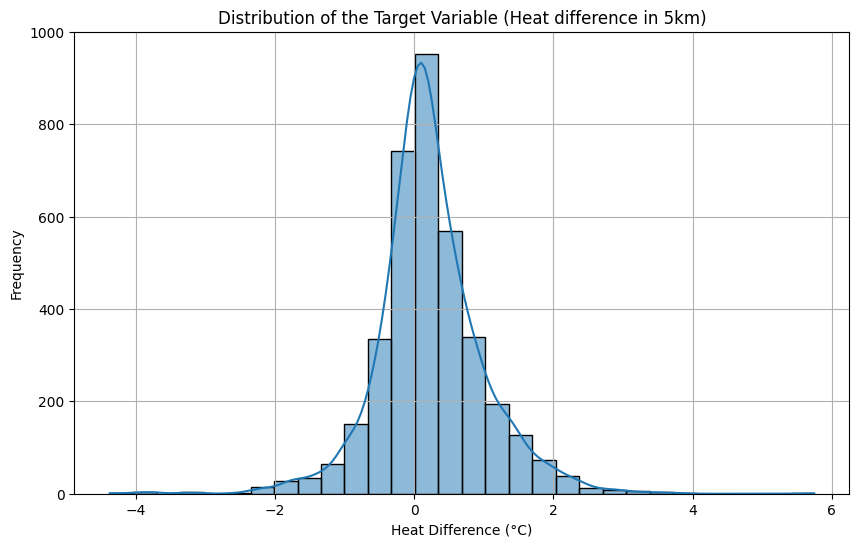

count    3709.000000
mean        0.226362
std         0.767441
min        -4.380003
25%        -0.170400
50%         0.167143
75%         0.594995
max         5.748238
Name: Heat difference in 5km, dtype: float64


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_complete['Heat difference in 5km'], kde=True, bins=30)
plt.title('Distribution of the Target Variable (Heat difference in 5km)')
plt.xlabel('Heat Difference (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_complete['Heat difference in 5km'].describe())

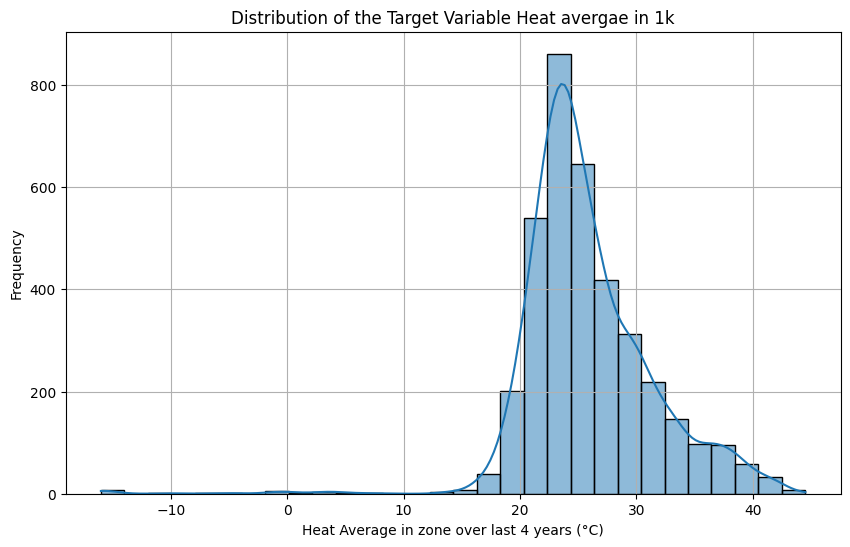

count    3709.000000
mean        0.226362
std         0.767441
min        -4.380003
25%        -0.170400
50%         0.167143
75%         0.594995
max         5.748238
Name: Heat difference in 5km, dtype: float64


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_complete['Heat average in 1k'], kde=True, bins=30)
plt.title('Distribution of the Target Variable Heat avergae in 1k')
plt.xlabel('Heat Average in zone over last 4 years (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_complete['Heat difference in 5km'].describe())

In [42]:
"""!pip install scikit-learn"""

'!pip install scikit-learn'

In [43]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

In [44]:

#x = df_complete[['Total reported direct emissions', 'High Heat', 'Mid Heat', 'Low Heat', 'Wind Speed 1km', 'Wind Speed 5km', 'Wind Speed 10km']].values
x = df_complete[['Latitude', 'Longitude', 'Total reported direct emissions','Stationary Combustion', 'Electricity Generation', 'Adipic Acid Production','Aluminum Production',
    'Ammonia Manufacturing', 'Cement Production', 'Electronics Manufacture', 'Ferroalloy Production',
    'Fluorinated GHG Production', 'Glass Production', 'HCFC-22 Production and HFC-23 Destruction',
    'Hydrogen Production', 'Iron and Steel Production', 'Lead Production','Lime Production',
    'Magnesium Production', 'Miscellaneous Use of Carbonates', 'Nitric Acid Production',
    'Petrochemical Production', 'Petroleum Refining','Phosphoric Acid Production',
    'Pulp and Paper Manufacturing', 'Silicon Carbide Production', 'Soda Ash Manufacturing',
    'SF6 from Electrical Equipment', 'Titanium Dioxide Production', 'Underground Coal Mines',
    'Zinc Production', 'Municipal Landfills', 'Industrial Wastewater Treatment',
    'Industrial Waste Landfills',
    'Offshore Production', 
    'Natural Gas Processing', 'Natural Gas Transmission/Compression',
    'Underground Natural Gas Storage','Liquified Natural Gas Storage',
    'Liquified Natural Gas Import/Export Equipment',
    'Petroleum Refinery (Producer)',
    'Petroleum Product Importer','Petroleum Product Exporter', 
    'Natural Gas Liquids Fractionator', 'Natural Gas Local Distribution Company (supply)',
    'Non-CO2 Industrial Gas Supply', 'Carbon Dioxide (CO2) Supply', 'Import and Export of Equipment Containing Fluorinated GHGs',
    # CO2 Injection
    'Injection of Carbon Dioxide',
    # Other
    'Electric Transmission and Distribution Equipment', 'Wind Speed 1km', 'Wind Speed 5km', 'Wind Speed 10km']].values

y = df_complete['Heat average in 1k'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_distributions = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.7, 0.8, 0.9, 1.0]
}


cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
# This test different combinations of the parameters using cross-validation.
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings that are sampled.
    cv=cv_strategy,
    scoring='r2', # The metric to evaluate the models on.
    n_jobs=-1,  # Use all available CPU cores.
    random_state=42,
    verbose=1 # Prints updates so you can see the progress.
)


print("Starting hyperparameter tuning...")
random_search.fit(x_train, y_train)

print("\n--- Tuning Complete ---")
print(f"Best R² score found during search: {random_search.best_score_:.4f}")
print("Best parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_
final_score = best_model.score(x_test, y_test)
print(f"\nFinal R² score on the unseen test set: {final_score:.4f}")



Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Tuning Complete ---
Best R² score found during search: 0.9015
Best parameters found:
{'model__subsample': 0.8, 'model__n_estimators': 500, 'model__max_depth': 7, 'model__learning_rate': 0.01}

Final R² score on the unseen test set: 0.9072


In [ ]:
import pickle
filename = 'industry_model.pkl'
with open(filename, 'wb') as file: 
    pickle.dump(best_model, file)

TypeError: file must have a 'write' attribute

### Al final, solo agarra este último cacho e implmentalo en el backend

In [ ]:
prediction = best_model.predict(data_to_predict)
#Data type: 
new_case = [
    # -- Location & Emissions --
    32.4,          # Latitude
    -110.9,        # Longitude
    50000,         # Total reported direct emissions. 

#This is calculated using the following constants from AR4

#gwp_ch4 = 25
#gwp_n2o = 298

#And this formula: 
# Total Reported direct emissions = 'Pollution_Index_CO2e' = 'CO2 emissions (non-biogenic)' * 1 + 'Methane (CH4) emissions' * gwp_ch4 + 'Nitrous Oxide (N2O) emissions'] * gwp_n2o

#Then a yes no for all industries that apply of the following list in the following order: 
"""
'Electricity Generation', 'Adipic Acid Production','Aluminum Production',
    'Ammonia Manufacturing', 'Cement Production', 'Electronics Manufacture', 'Ferroalloy Production',
    'Fluorinated GHG Production', 'Glass Production', 'HCFC-22 Production and HFC-23 Destruction',
    'Hydrogen Production', 'Iron and Steel Production', 'Lead Production','Lime Production',
    'Magnesium Production', 'Miscellaneous Use of Carbonates', 'Nitric Acid Production',
    'Petrochemical Production', 'Petroleum Refining','Phosphoric Acid Production',
    'Pulp and Paper Manufacturing', 'Silicon Carbide Production', 'Soda Ash Manufacturing',
    'SF6 from Electrical Equipment', 'Titanium Dioxide Production', 'Underground Coal Mines',
    'Zinc Production', 'Municipal Landfills', 'Industrial Wastewater Treatment',
    'Industrial Waste Landfills',
    'Offshore Production', 
    'Natural Gas Processing', 'Natural Gas Transmission/Compression',
    'Underground Natural Gas Storage','Liquified Natural Gas Storage',
    'Liquified Natural Gas Import/Export Equipment',
    'Petroleum Refinery (Producer)',
    'Petroleum Product Importer','Petroleum Product Exporter', 
    'Natural Gas Liquids Fractionator', 'Natural Gas Local Distribution Company (supply)',
    'Non-CO2 Industrial Gas Supply', 'Carbon Dioxide (CO2) Supply', 'Import and Export of Equipment Containing Fluorinated GHGs',
    # CO2 Injection
    'Injection of Carbon Dioxide',
    # Other
    'Electric Transmission and Distribution Equipment'
"""
    # -- One-Hot Encoded Industries (1 for yes, 0 for no) --
    1,             # Stationary Combustion? YES
    1,             # Electricity Generation? YES
    0,             # Adipic Acid Production? NO
    0,             # Aluminum Production? NO
    0,             # Ammonia Manufacturing? NO
    1,             # Cement Production? YES
                   # This applies for all the industries used to train the model. 
    *([0] * 43),   # This is a shortcut to add 43 zeros
    
#And the current wind speed on the lat-lon using a query as follows: 
    # -- Wind Speed --
    5.5,           # Wind Speed 1km
    5.8,           # Wind Speed 5km
    6.1            # Wind Speed 10km
]

#It needs all that apply from this list
